In [25]:
import sys
print(sys.executable)


/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/bin/python


# Zwei‑Stufen‑Modell mit XGBoost für EURUSD‑News

In diesem Notebook trainiere ich ein **Zwei‑Stufen‑Modell**, das aus News‑Features und Kursmerkmalen ableitet,

1. **Signal**: Gibt es eine signifikante Bewegung (`move`) oder bleibt der Kurs neutral?
2. **Richtung**: Wenn es eine Bewegung gibt – ist sie `up` oder `down`?

Die Labels wurden wie folgt definiert:

- Horizont: `horizon_days = 4` (Tage `t` bis `t+4`).
- Schwellen:
  - `up`: Lookahead‑Return `>= +1%`
  - `down`: Lookahead‑Return `<= −1%`
- Pfadbedingung: Streng monoton
  - `up`: `C_{t+1} > C_t`, `C_{t+2} > C_{t+1}`, `C_{t+3} > C_{t+2}`, `C_{t+4} > C_{t+3}`
  - `down`: entsprechend streng fallend.
- Alle übrigen Fälle werden als `neutral` gelabelt.

Aus diesen Labels wurden im Trainingsdatensatz zwei Zielvariablen abgeleitet:

- `signal`:
  - 0 = neutral
  - 1 = Bewegung (up oder down)
- `direction`:
  - 0 = down
  - 1 = up
  - NaN = neutral (wird für das Richtungs‑Modell ignoriert)

**XGBoost‑Modelle (Default‑Parameter in diesem Notebook)**

- Allgemein:
  - `max_depth = 3`
  - `learning_rate = 0.05`
  - `n_estimators = 400`
  - `subsample = 0.9`
  - `colsample_bytree = 0.9`
  - `random_state = 42`
  - `eval_metric = "logloss"`
  - `early_stopping_rounds = 50` auf dem Validierungs‑Split

- Stufe 1 (Signal‑Modell):
  - `objective = "binary:logistic"`
  - `scale_pos_weight ≈ N_neg / N_pos` (automatisch berechnet), um die seltene Klasse `move` zu gewichten.

- Stufe 2 (Richtungs‑Modell):
  - `objective = "binary:logistic"`
  - `scale_pos_weight = 1.0` (Klassen `down`/`up` sind relativ ausgeglichen).

**Eingabefeatures (FEATURE_COLS)**

Für beide Modelle werden die gleichen Features verwendet:

- News‑basierte Features:
  - `article_count` – Anzahl der News pro Tag
  - `avg_polarity` – mittlerer Sentiment‑Score (gesamt)
  - `avg_neg`, `avg_neu`, `avg_pos` – mittlere negative/neutral/positive Anteile
  - `pos_share`, `neg_share` – Relationen von `avg_pos` bzw. `avg_neg` zur Summe

- Kurs‑ und Kalender‑Features:
  - `intraday_range_pct` – (High − Low) / Close, Tages‑Volatilität
  - `upper_shadow`, `lower_shadow` – obere/untere Dochte (Abstand Körper zu High/Low)
  - `month`, `quarter` – Monat und Quartal des Datums

Die Daten stammen aus `data/processed/datasets/eurusd_news_training.csv` und umfassen die Jahre 2020 bis 2025.

**Ziel des Optimierens**

- Hohe **Precision** für:
  - `signal=1` (Tage mit Bewegung)
  - `direction` (richtige Vorhersage `up` vs. `down`),
- bei gleichzeitig **nicht zu schlechtem Recall** – d.h. das Modell soll zwar vorsichtig sein, aber trotzdem einen relevanten Anteil der Bewegungen erkennen.


In [26]:
import sys
from pathlib import Path

# von notebooks/notebooks/ zwei Ebenen hoch zur Projektwurzel
project_root = Path("..").resolve().parent
print("project_root:", project_root)

# Projektwurzel zum PYTHONPATH hinzufügen, damit `src.*` importierbar ist
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))



project_root: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project


## 1. Setup und Datensatz laden

In diesem Abschnitt:

- wird der Python‑Pfad so gesetzt, dass das `src`‑Paket im Notebook importierbar ist,
- werden die Hilfsfunktionen aus `src/models/train_xgboost_two_stage.py` importiert,
- und der vorbereitete Trainingsdatensatz `eurusd_news_training.csv` geladen.

Die Daten enthalten bereits alle Kurs‑ und News‑Features sowie die Zielvariablen `label`, `signal` und `direction`.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.train_xgboost_two_stage import (
    load_dataset,
    split_train_val_test,
    build_signal_targets,
    build_direction_targets,
    train_xgb_binary,
    FEATURE_COLS,
)

plt.style.use("seaborn-v0_8")

dataset_path = project_root / "data/processed/datasets/eurusd_news_training.csv"
df = load_dataset(dataset_path)

df.head()


,date,label,signal,direction,month,week,quarter,intraday_range,intraday_range_pct,body,...,upper_shadow,lower_shadow,pos_share,neg_share,lookahead_return,article_count,avg_polarity,avg_neg,avg_neu,avg_pos
0,2020-04-14,neutral,0,NaN,4,16,2,0.006822,0.006246,0.000346,...,0.006095,0.000381,0.415094,0.584906,-0.005129,1,-0.949,0.0930,0.8410,0.0660
1,2020-05-28,up,1,1.0,5,22,2,0.007875,0.007148,0.000158,...,0.005501,0.002216,0.519337,0.480663,0.015665,1,0.518,0.0870,0.8200,0.0940
2,2020-07-15,neutral,0,NaN,7,29,3,0.005945,0.005210,-0.000013,...,0.004216,0.001716,0.560440,0.439560,0.004205,1,0.847,0.0800,0.8180,0.1020
3,2020-07-22,up,1,1.0,7,30,3,0.009239,0.008010,-0.000106,...,0.006584,0.002549,0.595349,0.404651,0.020396,2,0.925,0.0870,0.7850,0.1280
4,2020-10-19,neutral,0,NaN,10,43,4,0.009029,0.007707,-0.000014,...,0.007960,0.001056,0.584459,0.415541,0.008495,4,0.944,0.0615,0.8515,0.0865


## 2. Klassenverteilungen untersuchen

Bevor wir Modelle trainieren, schaue ich mir an, wie die Klassen verteilt sind:

- `label` (3‑Klassen‑Ziel): `neutral`, `up`, `down`
- `signal` (Binary‑Ziel für Stufe 1): 0 = neutral, 1 = Bewegung
- `direction` (Binary‑Ziel für Stufe 2, nur bei Bewegung): 0 = down, 1 = up

Die Countplots machen die starke Klassenungleichverteilung sichtbar:
- Viele `neutral`‑Tage,
- relativ wenige Bewegungen (`up` und `down`).


Label-Verteilung (neutral/up/down):
label
neutral    1071
down         56
up           36
Name: count, dtype: int64

Signal-Verteilung (0=neutral, 1=move):
signal
0    1071
1      92
Name: count, dtype: int64

Direction (0=down, 1=up, ohne NaN):
direction
0.0    56
1.0    36
Name: count, dtype: int64


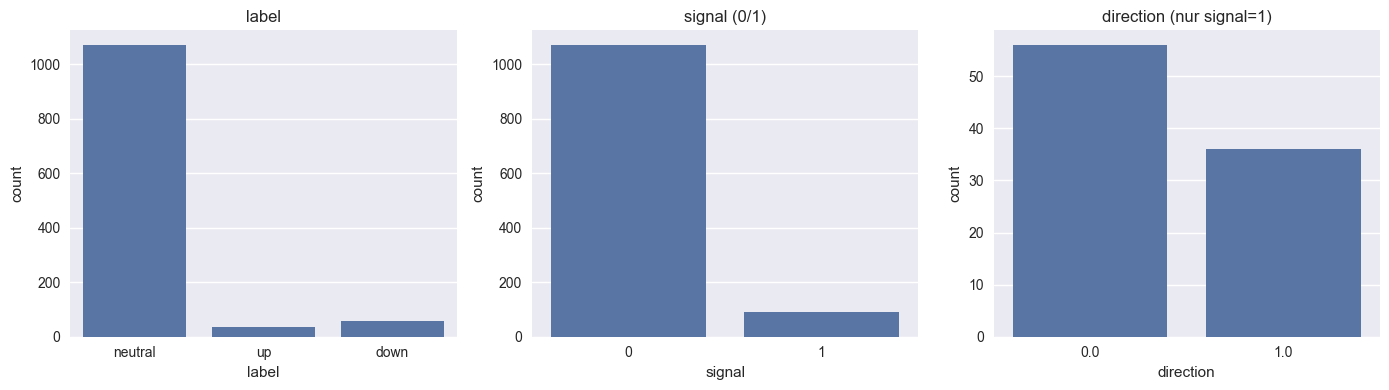

In [28]:
print("Label-Verteilung (neutral/up/down):")
print(df["label"].value_counts())

print("\nSignal-Verteilung (0=neutral, 1=move):")
print(df["signal"].value_counts())

print("\nDirection (0=down, 1=up, ohne NaN):")
print(df["direction"].value_counts(dropna=True))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.countplot(x="label", data=df, ax=axes[0])
axes[0].set_title("label")

sns.countplot(x="signal", data=df, ax=axes[1])
axes[1].set_title("signal (0/1)")

sns.countplot(x="direction", data=df[df["signal"] == 1], ax=axes[2])
axes[2].set_title("direction (nur signal=1)")

plt.tight_layout()
plt.show()


## 3. Zeitliche Train/Val/Test‑Splits

Um Data Leakage zu vermeiden, werden die Daten **chronologisch** aufgeteilt:

- **Test-Split**: alle Daten ab dem 1. Januar 2025.
- **Train+Validation**: alle Daten von 2020 bis Ende 2024, darin nochmal 80 % Train / 20 % Val.

So sieht das Modell den Testzeitraum beim Training nicht und wir erhalten eine realistische Out‑of‑Sample‑Bewertung.


In [29]:
# Test ab 2025-01-01, 80/20-Split innerhalb 2020–2024
splits = split_train_val_test(df, pd.to_datetime("2025-01-01"), train_frac_within_pretest=0.8)

for name, split_df in splits.items():
    print(f"{name}: {split_df['date'].min().date()} → {split_df['date'].max().date()} (n={len(split_df)})")


train: 2020-04-14 → 2024-04-09 (n=756)
val: 2024-04-10 → 2024-12-31 (n=189)
test: 2025-01-02 → 2025-11-05 (n=218)


## 4. Stufe 1 – Signal‑Modell (neutral vs move)

In dieser Stufe trainiere ich ein Binary‑XGBoost‑Modell auf:

- Ziel: `signal` (0 = neutral, 1 = Bewegung up/down)
- Features: News‑Sentiment + Volatilität + Schatten + Kalender (`FEATURE_COLS`)

Wegen der starken Klassenungleichverteilung verwende ich `scale_pos_weight ≈ N_neg / N_pos`
und Early Stopping auf dem Validierungs‑Split.


In [30]:
# Zielvariablen
y_train_signal = build_signal_targets(splits["train"])
y_val_signal = build_signal_targets(splits["val"])
y_test_signal = build_signal_targets(splits["test"])

X_train_signal = splits["train"][FEATURE_COLS]
X_val_signal = splits["val"][FEATURE_COLS]
X_test_signal = splits["test"][FEATURE_COLS]

model_signal = train_xgb_binary(
    X_train_signal, y_train_signal,
    X_val_signal, y_val_signal
)

model_signal


/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 5. Stufe 1 – Qualität des Signal‑Modells

Hier werte ich das Signal‑Modell für Train/Val/Test aus:

- Accuracy,
- Confusion‑Matrix,
- Classification‑Report (Precision, Recall, F1).

Besonders wichtig sind Precision und Recall der Klasse `1` (move).



=== TRAIN (SIGNAL) ===
Accuracy: 0.992
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.991     0.996       691
           1      0.915     1.000     0.956        65

    accuracy                          0.992       756
   macro avg      0.958     0.996     0.976       756
weighted avg      0.993     0.992     0.992       756



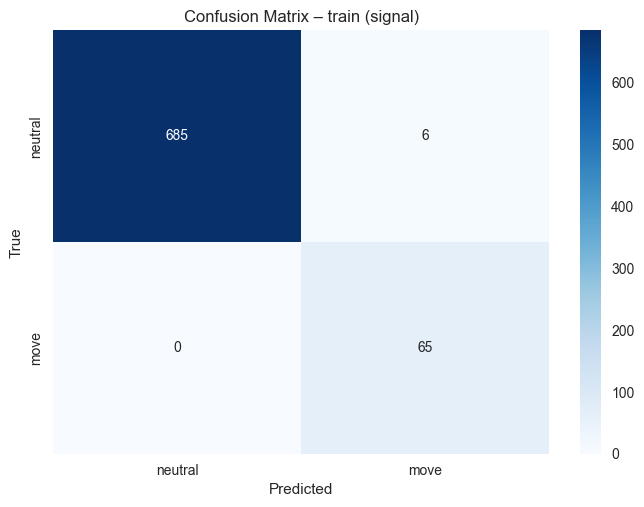


=== VAL (SIGNAL) ===
Accuracy: 0.937
Classification report:
              precision    recall  f1-score   support

           0      0.962     0.972     0.967       181
           1      0.167     0.125     0.143         8

    accuracy                          0.937       189
   macro avg      0.564     0.549     0.555       189
weighted avg      0.928     0.937     0.932       189



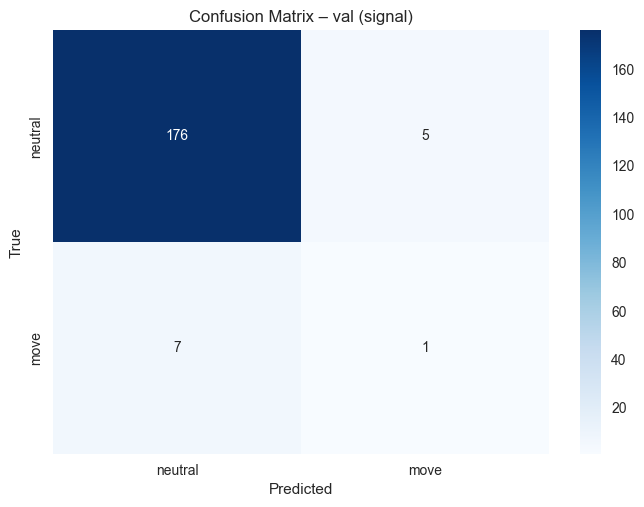


=== TEST (SIGNAL) ===
Accuracy: 0.904
Classification report:
              precision    recall  f1-score   support

           0      0.916     0.985     0.949       199
           1      0.250     0.053     0.087        19

    accuracy                          0.904       218
   macro avg      0.583     0.519     0.518       218
weighted avg      0.858     0.904     0.874       218



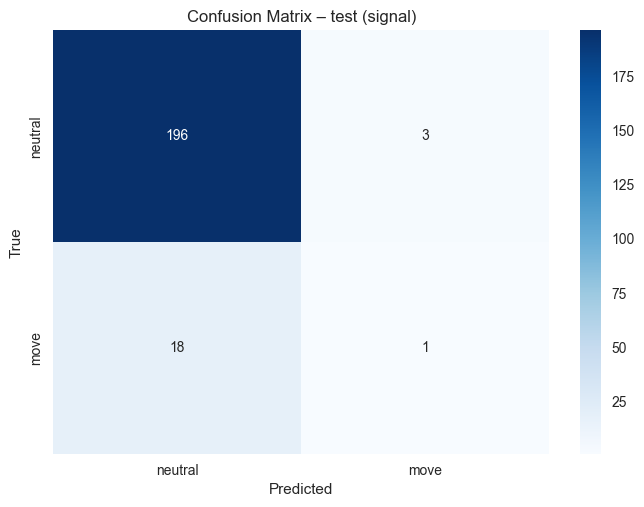

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def eval_and_plot(name, model, X, y_true):
    if len(X) == 0:
        print(f"[warn] {name} ist leer.")
        return
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name.upper()} ===")
    print(f"Accuracy: {acc:.3f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["neutral","move"],
                yticklabels=["neutral","move"])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

eval_and_plot("train (signal)", model_signal, X_train_signal, y_train_signal)
eval_and_plot("val (signal)", model_signal, X_val_signal, y_val_signal)
eval_and_plot("test (signal)", model_signal, X_test_signal, y_test_signal)


# X,y für Richtung (nur signal==1)
X_train_dir, y_train_dir = build_direction_targets(splits["train"])
X_val_dir, y_val_dir = build_direction_targets(splits["val"])
X_test_dir, y_test_dir = build_direction_targets(splits["test"])

# Hier bewusst kein Class-Weighting (scale_pos_weight=1.0)
model_dir = train_xgb_binary(
    X_train_dir, y_train_dir,
    X_val_dir, y_val_dir,
    scale_pos_weight=1.0
)

model_dir



=== TRAIN (DIRECTION) ===
Accuracy: 0.985
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.974     0.987        38
           1      0.964     1.000     0.982        27

    accuracy                          0.985        65
   macro avg      0.982     0.987     0.984        65
weighted avg      0.985     0.985     0.985        65



/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


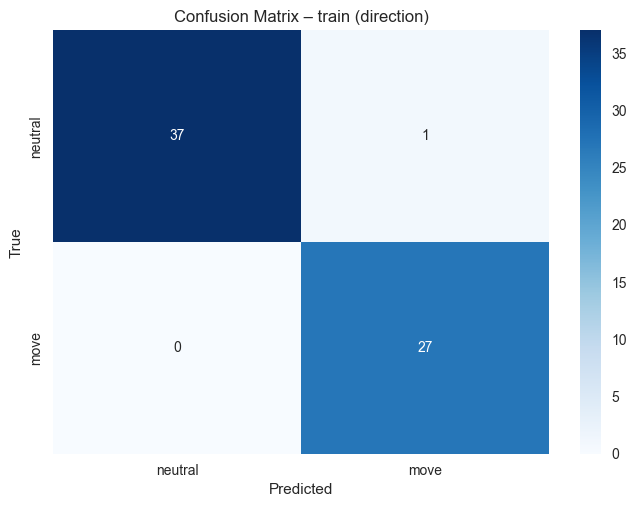


=== VAL (DIRECTION) ===
Accuracy: 0.875
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.857     0.923         7
           1      0.500     1.000     0.667         1

    accuracy                          0.875         8
   macro avg      0.750     0.929     0.795         8
weighted avg      0.938     0.875     0.891         8



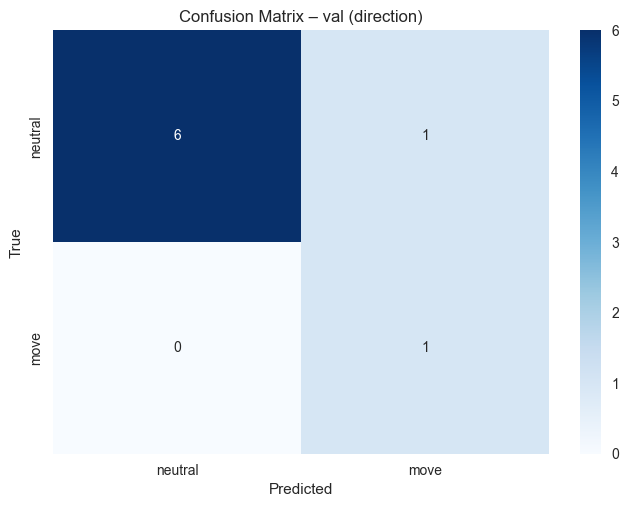


=== TEST (DIRECTION) ===
Accuracy: 0.895
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.818     0.900        11
           1      0.800     1.000     0.889         8

    accuracy                          0.895        19
   macro avg      0.900     0.909     0.894        19
weighted avg      0.916     0.895     0.895        19



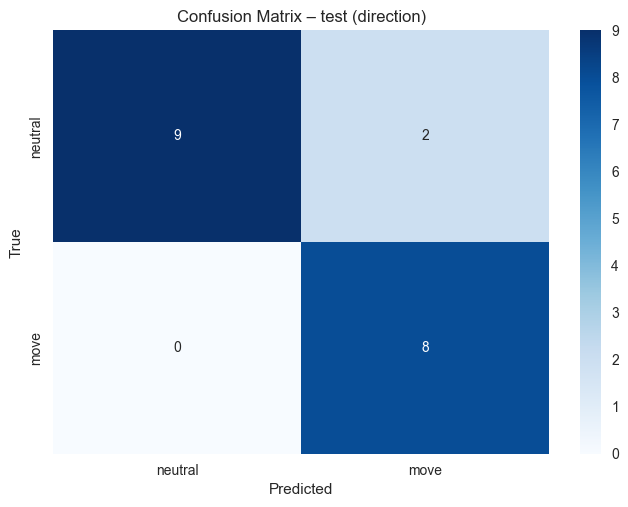

In [37]:
# X,y für Richtung (nur signal==1)
X_train_dir, y_train_dir = build_direction_targets(splits["train"])
X_val_dir, y_val_dir = build_direction_targets(splits["val"])
X_test_dir, y_test_dir = build_direction_targets(splits["test"])

# Kein Class-Weighting nötig, Klassen relativ ausgeglichen → scale_pos_weight=1.0
model_dir = train_xgb_binary(
    X_train_dir, y_train_dir,
    X_val_dir, y_val_dir,
    scale_pos_weight=1.0
)

eval_and_plot("train (direction)", model_dir, X_train_dir, y_train_dir)
eval_and_plot("val (direction)", model_dir, X_val_dir, y_val_dir)
eval_and_plot("test (direction)", model_dir, X_test_dir, y_test_dir)


## 8. Feature‑Importance

Um besser zu verstehen, welche Merkmale die Modelle tatsächlich nutzen, schaue ich mir
die Feature‑Importances der beiden XGBoost‑Modelle an:

- **Signal‑Modell** (neutral vs move): Welche Kombination aus News‑Sentiment, Volatilität,
  Schatten und Kalender ist wichtig, um Tage mit Bewegungen von neutralen Tagen zu unterscheiden?
- **Richtungs‑Modell** (up vs down): Welche Features helfen dabei, die Richtung einer Bewegung
  vorherzusagen, sobald ein Signal erkannt wurde?

Die Balkendiagramme sortieren die Features nach absteigender Wichtigkeit, basierend auf
den vom Modell gelernten Splits.


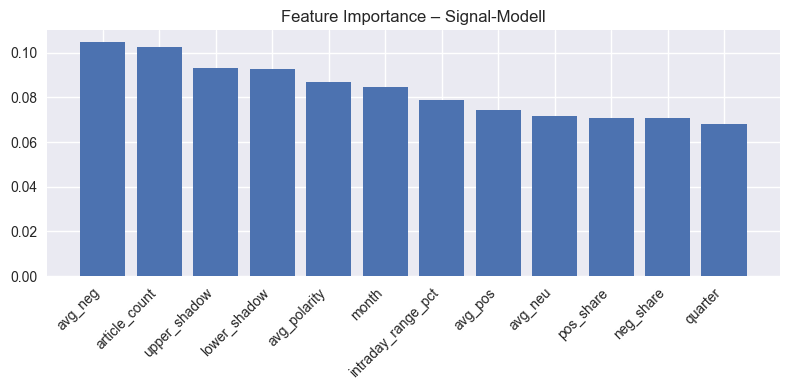

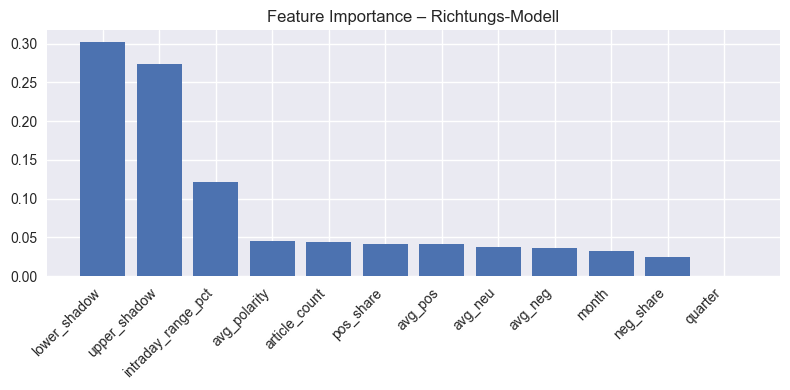

In [34]:
import numpy as np

def plot_feature_importance(model, title):
    importance = model.feature_importances_
    order = np.argsort(importance)[::-1]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(order)), importance[order])
    plt.xticks(range(len(order)),
               [FEATURE_COLS[i] for i in order],
               rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model_signal, "Feature Importance – Signal-Modell")
plot_feature_importance(model_dir, "Feature Importance – Richtungs-Modell")


## 9. Kombinierte 3‑Klassen‑Auswertung (neutral / up / down)

Zum Schluss kombiniere ich beide Stufen zu einem finalen 3‑Klassen‑Output:

1. Das Signal‑Modell entscheidet für jeden Test‑Tag:
   - `signal = 0` → endgültiges Label = `neutral`
   - `signal = 1` → es liegt eine Bewegung vor (`move`)
2. Nur wenn `signal = 1`, wird das Richtungs‑Modell aufgerufen:
   - `direction = 1` → endgültiges Label = `up`
   - `direction = 0` → endgültiges Label = `down`

Aus diesen beiden Modellen baue ich ein kombiniertes Label (`neutral`/`up`/`down`) und
vergleiche es mit der wahren `label`‑Spalte im Testzeitraum ab 2025. Die 3‑Klassen‑Confusion‑Matrix
und der Classification‑Report zeigen, wie gut das Gesamtsystem neutrale Tage von Bewegungen
und die Richtung der Bewegungen unterscheidet.


3-Klassen-Confusion-Matrix (rows=true, cols=pred):


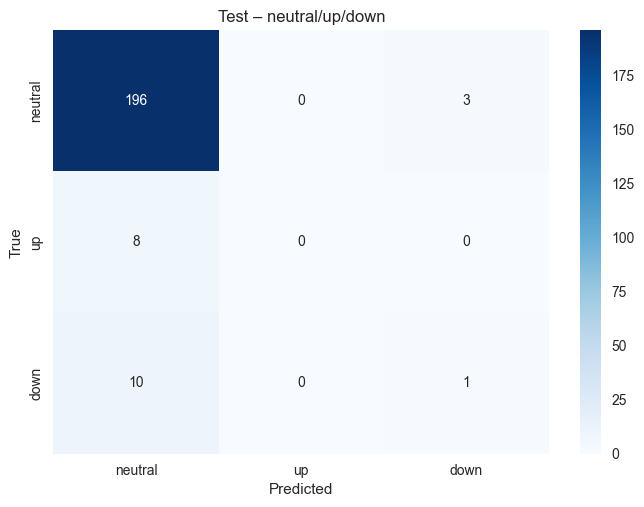


3-Klassen-Report:
              precision    recall  f1-score   support

        down      0.250     0.091     0.133        11
     neutral      0.916     0.985     0.949       199
          up      0.000     0.000     0.000         8

    accuracy                          0.904       218
   macro avg      0.389     0.359     0.361       218
weighted avg      0.849     0.904     0.873       218



/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

X_test_all = splits["test"][FEATURE_COLS]

signal_pred = (model_signal.predict_proba(X_test_all)[:, 1] >= 0.5).astype(int)
dir_pred = (model_dir.predict_proba(X_test_all)[:, 1] >= 0.5).astype(int)

combined_pred = np.where(
    signal_pred == 0,
    "neutral",
    np.where(dir_pred == 1, "up", "down"),
)
combined_true = splits["test"]["label"].to_numpy()

print("3-Klassen-Confusion-Matrix (rows=true, cols=pred):")
cm3 = confusion_matrix(combined_true, combined_pred, labels=["neutral","up","down"])
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neutral","up","down"],
            yticklabels=["neutral","up","down"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test – neutral/up/down")
plt.show()

print("\n3-Klassen-Report:")
print(classification_report(combined_true, combined_pred, digits=3))


## 10. Baseline-Ergebnisse speichern (v0)

Bevor ich weitere Experimente (z.B. andere Thresholds oder geänderte Label-Logik) durchführe,
möchte ich den aktuellen Stand des Zwei-Stufen-Modells festhalten.

In dieser Zelle speichere ich:

- die wichtigsten Hyperparameter / Einstellungen (Label-Logik, Features, Splits),
- die Metriken für das Signal-Modell (Train/Val/Test, Threshold = 0.5),
- die Metriken für das Richtungs-Modell (Train/Val/Test, Threshold = 0.5),
- die 3‑Klassen-Auswertung (`neutral` / `up` / `down`) auf dem Test-Split.

Alles wird als eine JSON-Datei unter `../results/two_stage_v0_h4_thr1pct_strict.json` abgelegt,
sodass ich die Baseline später leicht mit neuen Varianten vergleichen kann.


In [38]:
from pathlib import Path
import json
from sklearn.metrics import classification_report, confusion_matrix

# Ordner für Ergebnisse anlegen (relativ zum Notebook-Ordner)
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

# Ausgabedatei für diese Baseline-Konfiguration.
# Name enthält die wichtigsten Label-Parameter:
# - two_stage_v0: erste Version unseres Zwei-Stufen-Modells
# - h4: horizon_days = 4
# - thr1pct: ±1 % Lookahead-Schwellen
# - strict: strenge Monotonie-Bedingung
out_path = results_dir / "two_stage_v0_h4_thr1pct_strict.json"


def binary_metrics_dict(y_true, y_prob, threshold, target_names):
    """
    Hilfsfunktion, die für ein binäres Modell die wichtigsten Metriken
    in ein Dictionary schreibt.

    Parameter:
    - y_true: true Labels (0/1)
    - y_prob: vorhergesagte Wahrscheinlichkeit für Klasse 1 (shape: [n_samples])
    - threshold: Entscheidungsgrenze, ab der wir 1 vorhersagen
    - target_names: Namen der beiden Klassen, z.B. ["neutral", "move"]

    Rückgabe:
    - dict mit threshold, classification_report (als dict) und confusion_matrix (als Liste)
    """
    # Binäre Vorhersage aus den Wahrscheinlichkeiten ableiten
    y_pred = (y_prob >= threshold).astype(int)

    # Classification-Report in ein dict konvertieren (für JSON geeignet)
    report = classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        output_dict=True,
        digits=3,
    )

    # Confusion-Matrix als normale Python-Liste speichern
    cm = confusion_matrix(y_true, y_pred).tolist()

    return {
        "threshold": float(threshold),
        "report": report,
        "confusion_matrix": cm,
    }


# ---------------- Signal-Modell: Metriken für alle Splits ---------------- #

# Wahrscheinlichkeiten für Klasse 1 (move) je Split
probs_train_signal = model_signal.predict_proba(X_train_signal)[:, 1]
probs_val_signal = model_signal.predict_proba(X_val_signal)[:, 1]
probs_test_signal = model_signal.predict_proba(X_test_signal)[:, 1]

signal_metrics = {
    "train": binary_metrics_dict(
        y_true=y_train_signal,
        y_prob=probs_train_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
    "val": binary_metrics_dict(
        y_true=y_val_signal,
        y_prob=probs_val_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
    "test": binary_metrics_dict(
        y_true=y_test_signal,
        y_prob=probs_test_signal,
        threshold=0.5,
        target_names=["neutral", "move"],
    ),
}


# ---------------- Richtungs-Modell: Metriken für alle Splits ------------- #

# Wahrscheinlichkeiten für Klasse 1 (up) je Split
probs_train_dir = model_dir.predict_proba(X_train_dir)[:, 1]
probs_val_dir = model_dir.predict_proba(X_val_dir)[:, 1]
probs_test_dir = model_dir.predict_proba(X_test_dir)[:, 1]

direction_metrics = {
    "train": binary_metrics_dict(
        y_true=y_train_dir,
        y_prob=probs_train_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
    "val": binary_metrics_dict(
        y_true=y_val_dir,
        y_prob=probs_val_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
    "test": binary_metrics_dict(
        y_true=y_test_dir,
        y_prob=probs_test_dir,
        threshold=0.5,
        target_names=["down", "up"],
    ),
}


# ---------------- Kombinierte 3-Klassen-Auswertung auf Test -------------- #

# Für die kombinierte Auswertung verwenden wir alle Test-Tage (auch neutral)
X_test_all = splits["test"][FEATURE_COLS]

# Schritt 1: Signal-Vorhersage (0=neutral, 1=move)
signal_prob_test = model_signal.predict_proba(X_test_all)[:, 1]
signal_pred_test = (signal_prob_test >= 0.5).astype(int)

# Schritt 2: Richtungs-Vorhersage (nur relevant, wenn signal_pred_test == 1)
dir_prob_test = model_dir.predict_proba(X_test_all)[:, 1]
dir_pred_test = (dir_prob_test >= 0.5).astype(int)

# Endgültiges Label kombinieren:
# - wenn signal=0 → "neutral"
# - wenn signal=1 und direction=1 → "up"
# - wenn signal=1 und direction=0 → "down"
combined_pred = np.where(
    signal_pred_test == 0,
    "neutral",
    np.where(dir_pred_test == 1, "up", "down"),
)
combined_true = splits["test"]["label"].to_numpy()

combined_report = classification_report(
    combined_true,
    combined_pred,
    labels=["neutral", "up", "down"],
    output_dict=True,
    digits=3,
)
combined_cm = confusion_matrix(
    combined_true,
    combined_pred,
    labels=["neutral", "up", "down"],
).tolist()


# ---------------- Alles zusammen als JSON speichern --------------------- #

results = {
    "config": {
        # Wichtige Label-Parameter (Stand dieser Baseline)
        "horizon_days": 4,
        "up_threshold": 0.01,
        "down_threshold": -0.01,
        "strict_monotonic": True,
        # Meta-Infos zum Datensatz
        "dataset_path": str(dataset_path),
        "feature_cols": FEATURE_COLS,
        "test_start": "2025-01-01",
        "train_frac_within_pretest": 0.8,
    },
    "signal": signal_metrics,
    "direction": direction_metrics,
    "combined_test": {
        "report": combined_report,
        "confusion_matrix": combined_cm,
        "labels": ["neutral", "up", "down"],
    },
}

with open(out_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Baseline-Ergebnisse gespeichert unter: {out_path}")


Baseline-Ergebnisse gespeichert unter: ../results/two_stage_v0_h4_thr1pct_strict.json


/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w